In [603]:
import numpy as np
import pandas as pd
import os, json
from PIL import Image
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

In [605]:
#!pip install pykalman

### Data structure:
- Data is saved in JSON file format, and we can use Pandas' built-in function to read it as a DataFrame.
- We can examine the different columns and trial types.
- Different decision trials have various trial types.

In [608]:
sub_data = pd.read_json('cg_u1hzly9.json')

In [610]:
sub_data.columns

Index(['success', 'timeout', 'failed_images', 'failed_audio', 'failed_video',
       'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'browser_name', 'browser_type', 'subject', 'interaction', 'windowWidth',
       'windowHight', 'rt', 'response', 'stimulus', 'load_time', 'raw_gaze',
       'percent_in_roi', 'average_offset', 'validation_points',
       'samples_per_sec', 'task', 'webgazer_data', 'webgazer_targets'],
      dtype='object')

In [612]:
sub_data.trial_type.unique()

array(['preload', 'survey-text', 'fullscreen', 'html-keyboard-response',
       'webgazer-init-camera', 'webgazer-calibrate', 'webgazer-validate',
       'img-binary-choice', 'text-binary-choice', 'binary-three-states',
       'binary-two-states'], dtype=object)

### Validation Data Check:
- roi_radius (i.e., tolerance around validation point in pixels) is set to 200px 
- **validation_points**: Specific validation points in the data used for analysis. (unit: percentages of screen width and height)
- **samples per sec**: The average number of samples per second.
  - Calculated by finding the sampling rate for each point, then averaging these values together.
- **percent_in_roi**: The percentage of samples within the specified *roi_radius* for each validation point.
- **average_offset**: The average x and y distance from each validation point, plus the median distance r of the points from this average offset. (unit: )
- https://www.jspsych.org/v7/plugins/webgazer-validate/

In [615]:
wh = sub_data.windowHight.unique()[0]
ww = sub_data.windowWidth.unique()[0]
print("Window height: ", wh)
print("Window width: ", ww)

Window height:  1107
Window width:  1710


### Proportion of a 200px x 200px Area for a given participant

Given a window size of **1107 pixels** in height and **1710 pixels** in width, a 200px x 200px area would occupy the following proportions:

- **Width**: The 200px width would occupy approximately $( \frac{200}{1710} \approx 11.7\% )$ of the total window width.
- **Height**: The 200px height would occupy approximately $( \frac{200}{1107} \approx 18.1\% )$ of the total window height.


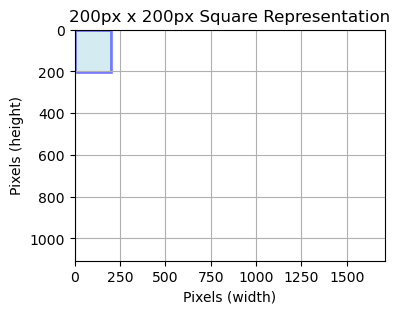

In [618]:
plt.figure(figsize=(4,3))
ax = plt.gca()
rect = patches.Rectangle((0.5, 0.5), 200, 200, linewidth=2, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(rect)
plt.xlim(0, ww)
plt.ylim(0, wh)
plt.title("200px x 200px Square Representation")
plt.xlabel("Pixels (width)")
plt.ylabel("Pixels (height)")

# Display plot
plt.gca().invert_yaxis()  # Inverting y-axis to match screen coordinates
plt.grid(True)
plt.show()

In [620]:
validation_points = sub_data.query("trial_type=='webgazer-validate'").validation_points.values
percent_in_roi = sub_data.query("trial_type=='webgazer-validate'").percent_in_roi.values
average_offset = sub_data.query("trial_type=='webgazer-validate'").average_offset.values
samples_per_sec = sub_data.query("trial_type=='webgazer-validate'").samples_per_sec.values
results_df = pd.DataFrame({
    "validation_points": validation_points,
    "percent_in_roi": percent_in_roi,
    "average_offset": average_offset,
    "samples_per_sec": samples_per_sec
})
results_df_exploded = results_df.apply(pd.Series.explode).reset_index(drop=True)
offset_df = pd.json_normalize(results_df_exploded['average_offset'])
offset_df.columns = ["offset_x", "offset_y", "offset_r"]
valipoints_df = pd.json_normalize(results_df_exploded['validation_points'])
valipoints_df.columns = ["validation_points_x", "validation_points_y"]

validation_df = pd.concat([results_df_exploded.drop(columns=['average_offset']), offset_df], axis=1)
validation_df[['validation_x', 'validation_y']] = pd.DataFrame(validation_df['validation_points'].tolist(), index=validation_df.index)
validation_df

validation_points percent_in_roi  samples_per_sec    offset_x   offset_y  \
0          [20, 20]            100            13.85   21.894737  -0.270559   
1          [20, 80]      94.117647            13.85   44.852941 -26.960018   
2          [80, 20]      91.666667            13.85  -43.694444  31.092014   
3          [50, 50]            100            13.85   12.411765  42.441176   
4          [20, 50]      91.428571            13.85  -23.885714  60.128571   
5          [50, 20]      82.051282            13.85   73.743590  15.305689   
6          [80, 80]      77.777778            13.85   -3.472222 -70.389757   
7          [80, 50]      94.594595            13.85    8.540541 -19.310811   
8          [50, 80]      74.358974            13.85  117.769231 -60.169671   

     offset_r  validation_x  validation_y  
0   81.253897            20            20  
1  104.321210            20            80  
2  100.240447            80            20  
3   88.329695            50            50  
4   72.476259            20            50  
5   93.739680            50            20  
6  128.717865            80            80  
7   82.889724            80            50  
8   87.655810            50            80

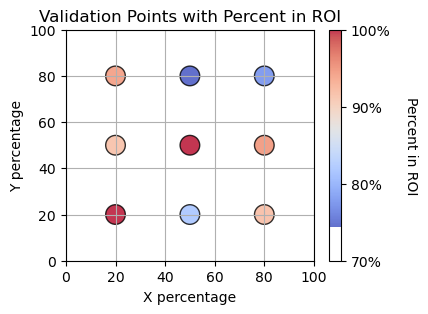

In [622]:
#visualize the validation data to understand if there is any biases towards different part of the screen
plt.figure(figsize=(4,3))
scatter = plt.scatter(validation_df['validation_x'], 
                      validation_df['validation_y'],
                      c=validation_df['percent_in_roi'], 
                      cmap='coolwarm', s=200, alpha=0.8, edgecolor='black', marker='o', label='Percent in ROI')

cbar = plt.colorbar(scatter, ticks=[0, 25, 50, 75, 100])
cbar.set_label("Percent in ROI", rotation=270, labelpad=20)
cbar.set_ticks([70,80,90,100])
cbar.set_ticklabels([ '70%','80%', '90%','100%'])
plt.xlim(0,100)
plt.ylim(0,100)
# Adding labels, legend, and grid
plt.title("Validation Points with Percent in ROI")
plt.xlabel("X percentage")
plt.ylabel("Y percentage")
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

#### Visualization of Gaze Predictions During Food and Charity Choices:
- For choices featuring only stimuli on the left or right side, Webgazer performs reasonably well in predicting where people look.
- However, distinguishing whether people are gazing at the slogan (in charity decisions) or the image can be challenging.

In [625]:
gaze_data = sub_data.query("trial_type == 'img-binary-choice'").webgazer_data.values[0]
gaze_region = sub_data.query("trial_type == 'img-binary-choice'").webgazer_targets.values[0]
gaze_x = [point['x'] for point in gaze_data]
gaze_y = [point['y'] for point in gaze_data]
gaze_x_left = [point['x'] for point in gaze_data if gaze_region['#left_state']['x'] <= point['x'] <= gaze_region['#left_state']['x'] + gaze_region['#left_state']['width'] and gaze_region['#left_state']['y'] <= point['y'] <= gaze_region['#left_state']['y'] + gaze_region['#left_state']['height']]
gaze_y_left = [point['y'] for point in gaze_data if gaze_region['#left_state']['x'] <= point['x'] <= gaze_region['#left_state']['x'] + gaze_region['#left_state']['width'] and gaze_region['#left_state']['y'] <= point['y'] <= gaze_region['#left_state']['y'] + gaze_region['#left_state']['height']]
gaze_x_right = [point['x'] for point in gaze_data if gaze_region['#right_state']['x'] <= point['x'] <= gaze_region['#right_state']['x'] + gaze_region['#right_state']['width'] and gaze_region['#right_state']['y'] <= point['y'] <= gaze_region['#right_state']['y'] + gaze_region['#right_state']['height']]
gaze_y_right = [point['y'] for point in gaze_data if gaze_region['#right_state']['x'] <= point['x'] <= gaze_region['#right_state']['x'] + gaze_region['#right_state']['width'] and gaze_region['#right_state']['y'] <= point['y'] <= gaze_region['#right_state']['y'] + gaze_region['#right_state']['height']]


In [626]:
food_image_path = sub_data.query("trial_type == 'img-binary-choice'").stimulus.values[0]
left_img = Image.open('../public/' +food_image_path[0] )
right_img = Image.open('../public/' +food_image_path[1] )

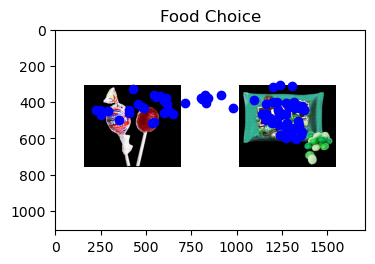

In [629]:
fig, ax = plt.subplots(figsize=(4,3))

# Draw the left target rectangle
ax.add_patch(patches.Rectangle(
    (gaze_region['#left_state']['x'], gaze_region['#left_state']['y']),
    gaze_region['#left_state']['width'], gaze_region['#left_state']['height'],
    facecolor='none', lw=2, label='Left Target'
))

# Draw the right target rectangle
ax.add_patch(patches.Rectangle(
    (gaze_region['#right_state']['x'], gaze_region['#right_state']['y']),
    gaze_region['#right_state']['width'], gaze_region['#right_state']['height'],
    facecolor='none', lw=2, label='Right Target'
))

ax.imshow(left_img, extent=(
    gaze_region['#left_state']['x'],
    gaze_region['#left_state']['x'] + gaze_region['#left_state']['width'],
    gaze_region['#left_state']['y'] + gaze_region['#left_state']['height'],
    gaze_region['#left_state']['y']
))

ax.set_xlim(0, ww)
ax.set_ylim(0, wh)
ax.set_title('Food Choice')
ax.invert_yaxis() 

# Right Image
ax.imshow(right_img, extent=(
    gaze_region['#right_state']['x'],
    gaze_region['#right_state']['x'] + gaze_region['#right_state']['width'],
    gaze_region['#right_state']['y'] + gaze_region['#right_state']['height'],
    gaze_region['#right_state']['y']
))

scatter = ax.plot([], [], 'bo')[0]  # 'bo' for blue points

# Function to initialize the plot
def init():
    scatter.set_data([], [])
    return scatter,

# Function to update each frame
def update(frame):
    scatter.set_data(gaze_x[:frame], gaze_y[:frame])
    return scatter,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(gaze_data), init_func=init, blit=True)

from IPython.display import HTML
HTML(ani.to_jshtml())
#ani.save('food_gaze_animation.gif', writer='pillow', fps=10)
#plt.close(fig)  #

In [631]:
gaze_data = sub_data.query("trial_type == 'img-binary-choice'").webgazer_data.values[1]
gaze_region = sub_data.query("trial_type == 'img-binary-choice'").webgazer_targets.values[1]
gaze_x = [point['x'] for point in gaze_data]
gaze_y = [point['y'] for point in gaze_data]
gaze_x_left = [point['x'] for point in gaze_data if gaze_region['#left_state']['x'] <= point['x'] <= gaze_region['#left_state']['x'] + gaze_region['#left_state']['width'] and gaze_region['#left_state']['y'] <= point['y'] <= gaze_region['#left_state']['y'] + gaze_region['#left_state']['height']]
gaze_y_left = [point['y'] for point in gaze_data if gaze_region['#left_state']['x'] <= point['x'] <= gaze_region['#left_state']['x'] + gaze_region['#left_state']['width'] and gaze_region['#left_state']['y'] <= point['y'] <= gaze_region['#left_state']['y'] + gaze_region['#left_state']['height']]
gaze_x_right = [point['x'] for point in gaze_data if gaze_region['#right_state']['x'] <= point['x'] <= gaze_region['#right_state']['x'] + gaze_region['#right_state']['width'] and gaze_region['#right_state']['y'] <= point['y'] <= gaze_region['#right_state']['y'] + gaze_region['#right_state']['height']]
gaze_y_right = [point['y'] for point in gaze_data if gaze_region['#right_state']['x'] <= point['x'] <= gaze_region['#right_state']['x'] + gaze_region['#right_state']['width'] and gaze_region['#right_state']['y'] <= point['y'] <= gaze_region['#right_state']['y'] + gaze_region['#right_state']['height']]


In [632]:
charity_image_path = sub_data.query("trial_type == 'img-binary-choice'").stimulus.values[1]
left_img = Image.open('../public/' +charity_image_path[0] )
right_img = Image.open('../public/' +charity_image_path[1] )

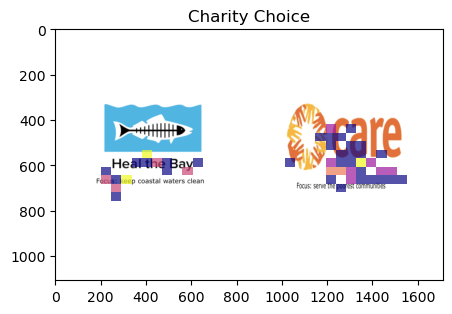

In [633]:
fig, ax = plt.subplots(figsize=(5,4))

# Draw the left target rectangle
ax.add_patch(patches.Rectangle(
    (gaze_region['#left_state']['x'], gaze_region['#left_state']['y']),
    gaze_region['#left_state']['width'], gaze_region['#left_state']['height'],
    facecolor='none', lw=2, label='Left Target'
))

# Draw the right target rectangle
ax.add_patch(patches.Rectangle(
    (gaze_region['#right_state']['x'], gaze_region['#right_state']['y']),
    gaze_region['#right_state']['width'], gaze_region['#right_state']['height'],
    facecolor='none', lw=2, label='Right Target'
))

ax.imshow(left_img, extent=(
    gaze_region['#left_state']['x'],
    gaze_region['#left_state']['x'] + gaze_region['#left_state']['width'],
    gaze_region['#left_state']['y'] + gaze_region['#left_state']['height'],
    gaze_region['#left_state']['y']
))

# Right Image
ax.imshow(right_img, extent=(
    gaze_region['#right_state']['x'],
    gaze_region['#right_state']['x'] + gaze_region['#right_state']['width'],
    gaze_region['#right_state']['y'] + gaze_region['#right_state']['height'],
    gaze_region['#right_state']['y']
))
# Update colormap to 'plasma' for better visibility
if gaze_x_left and gaze_y_left:
    left_heatmap, xedges, yedges = np.histogram2d(gaze_x_left, gaze_y_left, bins=12, range=[[gaze_region['#left_state']['x'], gaze_region['#left_state']['x'] + gaze_region['#left_state']['width']], [gaze_region['#left_state']['y'], gaze_region['#left_state']['y'] + gaze_region['#left_state']['height']]])
    # Mask zero values to make them transparent
    left_heatmap = np.ma.masked_where(left_heatmap == 0, left_heatmap)
    ax.imshow(left_heatmap.T, extent=(gaze_region['#left_state']['x'], gaze_region['#left_state']['x'] + gaze_region['#left_state']['width'], gaze_region['#left_state']['y'], gaze_region['#left_state']['y'] + gaze_region['#left_state']['height']), origin='lower', cmap="plasma", alpha=0.7)  # Adjust alpha for visibility

if gaze_x_right and gaze_y_right:
    right_heatmap, xedges, yedges = np.histogram2d(gaze_x_right, gaze_y_right, bins=12, range=[[gaze_region['#right_state']['x'], gaze_region['#right_state']['x'] + gaze_region['#right_state']['width']], [gaze_region['#right_state']['y'], gaze_region['#right_state']['y'] + gaze_region['#right_state']['height']]])
    # Mask zero values to make them transparent
    right_heatmap = np.ma.masked_where(right_heatmap == 0, right_heatmap)
    ax.imshow(right_heatmap.T, extent=(gaze_region['#right_state']['x'], gaze_region['#right_state']['x'] + gaze_region['#right_state']['width'], gaze_region['#right_state']['y'], gaze_region['#right_state']['y'] + gaze_region['#right_state']['height']), origin='lower', cmap="plasma", alpha=0.7)  # Adjust alpha for visibility

plt.xlim(0, ww)
plt.ylim(0, wh)
plt.title('Charity Choice')
plt.gca().invert_yaxis()  # Invert y-axis if necessary to match screen coordinates
plt.show()

#### Gaze cascade effect:
- The gaze cascade effect is a phenomenon where a person's gaze gradually shifts toward the stimulus they eventually choose.
- We can plot the distance between the gaze prediction and the center of the chosen target to examine whether the participant’s predicted gaze is indeed more likely to remain on the chosen option.
- The raw gaze data is noisy and subject to artifacts like saccades and blinks. We can try different smoothing techniques to help reduce high-frequency noise.

In [635]:
cols = ['response','trial_index','webgazer_data','webgazer_targets']
sub_data2 = sub_data.query("trial_type == 'img-binary-choice'").explode('webgazer_data')[cols]

In [636]:
from pykalman import KalmanFilter
from scipy.signal import savgol_filter
gaze_data = sub_data2.webgazer_data.values
def kalman_filter_gaze(x, y):
    initial_state = [x[0], y[0]]
    kf = KalmanFilter(initial_state_mean=initial_state, n_dim_obs=2)
    smoothed_state_means, _ = kf.smooth(np.column_stack((x, y)))
    return smoothed_state_means[:, 0], smoothed_state_means[:, 1]


x_coords = [point['x'] for point in gaze_data]
y_coords = [point['y'] for point in gaze_data]
time_points = [point['t'] for point in gaze_data]

filtered_x_all, filtered_y_all = kalman_filter_gaze(x_coords, y_coords)
sub_data2['filtered_x_all'] = filtered_x_all
sub_data2['filtered_y_all'] = filtered_y_all

In [637]:
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
distances = []
distance_filters = []

for idx, row in sub_data2.iterrows():
    if row['response'] == 'f':
        target = row['webgazer_targets']['#left_state']
    elif row['response'] == 'j':
        target = row['webgazer_targets']['#right_state']
    else:
        target = None
    # Calculate distance 
    if target:
        gaze_x, gaze_y = row['webgazer_data']['x'], row['webgazer_data']['y']
        target_x, target_y = target['x'] + 1/2*  target['width'], target['y']+ 1/2*  target['height']
        distance = calculate_distance(gaze_x, gaze_y, target_x, target_y)
        distances.append(distance)
        
        filtered_x, filtered_y = row['filtered_x_all'], row['filtered_y_all']  # Placeholder for actual filtered values
        distance_filter = calculate_distance(filtered_x, filtered_y, target_x, target_y)
        distance_filters.append(distance_filter)
   
sub_data2['distance_to_chosen_option'] = distances
sub_data2['distance_filter_to_chosen_option'] = distance_filters
sub_data2 = sub_data2[['response', 'trial_index','webgazer_data', 'webgazer_targets', 'distance_to_chosen_option','distance_filter_to_chosen_option']]

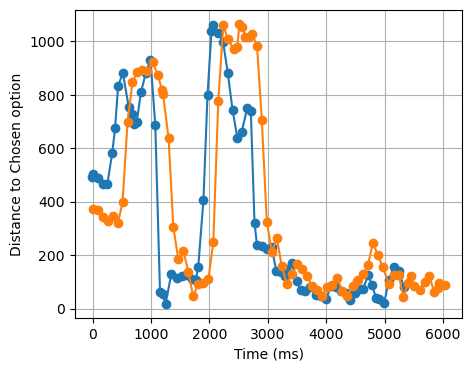

In [645]:
sub_data2['time'] = sub_data2['webgazer_data'].apply(lambda x: x['t'])
# Plotting
plt.figure(figsize=(5, 4))
for trial_index in sub_data2['trial_index'].unique():
    trial_data = sub_data2[sub_data2['trial_index'] == trial_index]
    plt.plot(trial_data['time'], trial_data['distance_to_chosen_option'], marker='o', linestyle='-', label=f'Trial {trial_index}')
plt.xlabel('Time (ms)')
plt.ylabel('Distance to Chosen option')
#plt.title('Distance to Chosen option Over Time')
plt.grid()
plt.show()


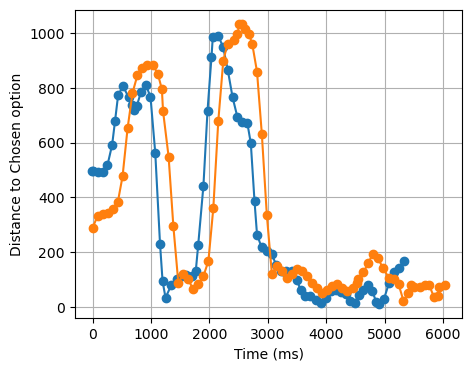

In [647]:
# apply smoothing techniques
sub_data2['time'] = sub_data2['webgazer_data'].apply(lambda x: x['t'])
# Plotting
plt.figure(figsize=(5, 4))
for trial_index in sub_data2['trial_index'].unique():
    trial_data = sub_data2[sub_data2['trial_index'] == trial_index]
    plt.plot(trial_data['time'], trial_data['distance_filter_to_chosen_option'], marker='o', linestyle='-', label=f'Trial {trial_index}')
plt.xlabel('Time (ms)')
plt.ylabel('Distance to Chosen option')
plt.grid()
plt.show()

#### Define ROI (use the intertemporal choice as an example):
- In order to pre-process the data into the fixation level, we need to define Region of Interests.
- how big should ROIs be? (source: [Tobii Eye-tracking website](https://connect.tobii.com/s/article/digging-into-areas-of-interest-aois?language=en_US#:~:text=Areas%20of%20Interest%20(AOIs)%20are,over%20the%20time%20of%20interest.))
   - Making ROIs the “right size"
       - To properly answer this design question, the researcher must decide on the proper balance between selectivity and sensitivity. In other words, how much of the gaze data around a target to include in the AOI calculation. Smaller AOIs increase selectivity and exclude more extraneous gaze at the risk of losing some actual valid looking. Larger AOIs increase sensitivity and may include more extraneous data while potentially capturing more of the actual looking to target. The choice will depend on a number of factors, including the data quality, one’s research questions and the statistics employed. 
    - Putting AOIs in the “right place”
       - This issue goes hand in hand with the preceding as it’s common to have multiple AOIs on a stimulus image, website, or package. Because of this, the space between AOIs may also be a factor in calculating accurate and meaningful gaze metrics. Wherever possible, ensure that adjacent AOIs have sufficient spacing by checking the accuracy of your calibrations and applying a greater distance between your AOIs.

In [650]:
gaze_data = sub_data[sub_data.trial_type == 'binary-two-states'].webgazer_data.values[0]
gaze_region = sub_data[sub_data.trial_type == 'binary-two-states'].webgazer_targets.values[0]
text_choice = sub_data[sub_data.trial_type == 'binary-two-states'].stimulus.values[0]
gaze_x = [point['x'] for point in gaze_data]
gaze_y = [point['y'] for point in gaze_data]
text_option_upperleft = text_choice[0]
text_option_lowerleft = text_choice[1]
text_option_upperright = text_choice[2]
text_option_lowerright = text_choice[3]

In [652]:
# let's try add 10% percent of the window width and 30% window height and see how it looks like 
marginWidth = 0.1*ww
marginHeight = 0.3*wh

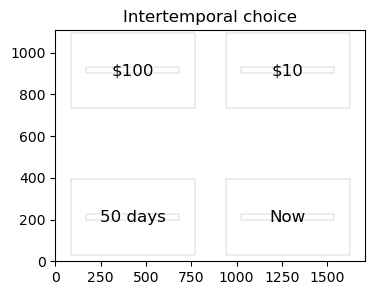

In [654]:
fig, ax = plt.subplots(figsize=(4,3))


ax.add_patch(patches.Rectangle(
    (gaze_region['#upperleft-div']['x'], gaze_region['#upperleft-div']['y']),
    gaze_region['#upperleft-div']['width'], gaze_region['#upperleft-div']['height'],
      edgecolor='black', facecolor='none', lw=0.1,
))

ax.add_patch(patches.Rectangle(
    (gaze_region['#upperleft-div']['x']-1/2*marginWidth, gaze_region['#upperleft-div']['y']-1/2*marginHeight),
    gaze_region['#upperleft-div']['width']+marginWidth, gaze_region['#upperleft-div']['height']+marginHeight,
      edgecolor='black', facecolor='none', lw=0.1,
))
ax.add_patch(patches.Rectangle(
    (gaze_region['#upperright-div']['x'], gaze_region['#upperright-div']['y']),
    gaze_region['#upperright-div']['width'], gaze_region['#upperright-div']['height'],
    edgecolor='black', facecolor='none', lw=0.1, 
))

ax.add_patch(patches.Rectangle(
    (gaze_region['#upperright-div']['x']-1/2*marginWidth, gaze_region['#upperright-div']['y']-1/2*marginHeight),
    gaze_region['#upperright-div']['width']+marginWidth, gaze_region['#upperright-div']['height']+marginHeight,
    edgecolor='black', facecolor='none', lw=0.1, 
))

ax.add_patch(patches.Rectangle(
    (gaze_region['#lowerleft-div']['x'], gaze_region['#lowerleft-div']['y']),
    gaze_region['#lowerleft-div']['width'], gaze_region['#lowerleft-div']['height'],
      edgecolor='black', facecolor='none', lw=0.1,
))

ax.add_patch(patches.Rectangle(
    (gaze_region['#lowerleft-div']['x']-1/2*marginWidth, gaze_region['#lowerleft-div']['y']-1/2*marginHeight),
    gaze_region['#lowerleft-div']['width']+marginWidth, gaze_region['#lowerleft-div']['height']+marginHeight,
      edgecolor='black', facecolor='none', lw=0.1,
))

ax.add_patch(patches.Rectangle(
    (gaze_region['#lowerright-div']['x'], gaze_region['#lowerright-div']['y']),
    gaze_region['#lowerright-div']['width'], gaze_region['#lowerright-div']['height'],
    edgecolor='black', facecolor='none', lw=0.1, 
))

ax.add_patch(patches.Rectangle(
    (gaze_region['#lowerright-div']['x']-1/2*marginWidth, gaze_region['#lowerright-div']['y']-1/2*marginHeight),
    gaze_region['#lowerright-div']['width']+marginWidth, gaze_region['#lowerright-div']['height']+marginHeight,
      edgecolor='black', facecolor='none', lw=0.1,
))

# Place text in the rectangles
ax.text(gaze_region['#upperleft-div']['x'] + gaze_region['#upperleft-div']['width'] / 2,
        gaze_region['#upperleft-div']['y'] + gaze_region['#upperleft-div']['height'] / 2,
        text_option_upperleft, ha='center', va='center', fontsize=12, color='black')

ax.text(gaze_region['#upperright-div']['x'] + gaze_region['#upperright-div']['width'] / 2,
        gaze_region['#upperright-div']['y'] + gaze_region['#upperright-div']['height'] / 2,
        text_option_upperright, ha='center', va='center', fontsize=12, color='black')

ax.text(gaze_region['#lowerleft-div']['x'] + gaze_region['#lowerleft-div']['width'] / 2,
        gaze_region['#lowerleft-div']['y'] + gaze_region['#lowerleft-div']['height'] / 2,
        text_option_lowerleft, ha='center', va='center', fontsize=12, color='black')

ax.text(gaze_region['#lowerright-div']['x'] + gaze_region['#lowerright-div']['width'] / 2,
        gaze_region['#lowerright-div']['y'] + gaze_region['#lowerright-div']['height'] / 2,
        text_option_lowerright, ha='center', va='center', fontsize=12, color='black')

plt.title("Intertemporal choice")
plt.gca().invert_yaxis()
plt.xlim(0, ww)
plt.ylim(0, wh)
plt.show()

### Fixation/Dwell level data
 - Column "t" indicates the time that passed since the initialisation of the webgazer module. It doesn't always coincide with the start of the screen, but it still is a fixed point in the task history.
 -  If the blank fixations were recorded between fixations on the same item, then those blank fixations were changed to that item. So, for example, a fixation pattern of ‘Left’, ‘Blank’, ‘Left’ would become ‘Left’, ‘Left’, ‘Left’.



In [657]:
delayed_choice = sub_data.loc[sub_data.trial_type == 'binary-two-states'].iloc[0]
trial_dict = {'upperleft' : delayed_choice['stimulus'][0],
 'lowerleft' : delayed_choice['stimulus'][1],
'upperright' : delayed_choice['stimulus'][2],
'lowerright' : delayed_choice['stimulus'][3],
 'choice': delayed_choice.response,
 'rt': delayed_choice.rt,
 'upperleft_target' : delayed_choice['webgazer_targets']['#upperleft-div'],
 'lowerleft_target' : delayed_choice['webgazer_targets']['#lowerleft-div'],
 'upperright_target' : delayed_choice['webgazer_targets']['#upperright-div'],
 'lowerrright_target' : delayed_choice['webgazer_targets']['#lowerright-div'],
 'gaze_data':delayed_choice['webgazer_data']
}
trial_df = pd.DataFrame([trial_dict]).explode('gaze_data').reset_index(drop=True)

In [659]:
def get_target_region(gaze_point, row,marginWidth,marginHeight):
    targets = {
        'upperleft_target': row['upperleft_target'],
        'lowerleft_target': row['lowerleft_target'],
        'upperright_target': row['upperright_target'],
        'lowerrright_target': row['lowerrright_target']
    }
    
    for region_name, target in targets.items():
        if (target['x'] - 1/2*marginWidth <= gaze_point['x'] <= target['x'] + target['width'] + marginWidth) and \
           (target['y'] - 1/2*marginHeight <= gaze_point['y'] <= target['y'] + target['height'] + marginHeight):
            return region_name  # Return the name of the region if the gaze point is within it
    
    return 0  # Return 0 if the gaze point is not within any region


In [661]:
trial_df['roi'] = trial_df.apply(lambda row: get_target_region(row['gaze_data'], row,marginWidth,marginHeight), axis=1)
trial_df['time_elapsed'] = trial_df.apply(lambda row: row['gaze_data']['t'],axis=1)
trial_fixation_data = trial_df[['upperleft','lowerleft','upperright','lowerright','choice','rt','roi','time_elapsed']]
trial_fixation_data = trial_fixation_data[(trial_fixation_data['time_elapsed'] >=0) \
                                & (trial_fixation_data['time_elapsed']<=trial_fixation_data['rt'])]
trial_fixation_data = trial_fixation_data[trial_fixation_data['roi']!=0]
trial_fixation_data.head(20)

upperleft lowerleft upperright lowerright choice      rt               roi  \
1    50 days      $100        Now        $10      f  9886.0  upperleft_target   
2    50 days      $100        Now        $10      f  9886.0  upperleft_target   
7    50 days      $100        Now        $10      f  9886.0  upperleft_target   
8    50 days      $100        Now        $10      f  9886.0  upperleft_target   
9    50 days      $100        Now        $10      f  9886.0  upperleft_target   
10   50 days      $100        Now        $10      f  9886.0  upperleft_target   
11   50 days      $100        Now        $10      f  9886.0  upperleft_target   
12   50 days      $100        Now        $10      f  9886.0  upperleft_target   
13   50 days      $100        Now        $10      f  9886.0  upperleft_target   
14   50 days      $100        Now        $10      f  9886.0  upperleft_target   
15   50 days      $100        Now        $10      f  9886.0  upperleft_target   
16   50 days      $100        Now        $10      f  9886.0  upperleft_target   
17   50 days      $100        Now        $10      f  9886.0  upperleft_target   
19   50 days      $100        Now        $10      f  9886.0  lowerleft_target   
20   50 days      $100        Now        $10      f  9886.0  lowerleft_target   
21   50 days      $100        Now        $10      f  9886.0  lowerleft_target   
22   50 days      $100        Now        $10      f  9886.0  lowerleft_target   
23   50 days      $100        Now        $10      f  9886.0  lowerleft_target   
24   50 days      $100        Now        $10      f  9886.0  lowerleft_target   
25   50 days      $100        Now        $10      f  9886.0  lowerleft_target   

    time_elapsed  
1              0  
2            102  
7            451  
8            533  
9            613  
10           694  
11           776  
12           843  
13           916  
14           979  
15          1045  
16          1126  
17          1206  
19          1375  
20          1459  
21          1502  
22          1555  
23          1651  
24          1741  
25          1824

In [663]:
def assign_fixation_numbers(df, roi_column='roi', fixation_column='fixation_number'):
    """
    Assign fixation numbers based on changes in the `roi` column.
    """
    # Initialize fixation number and list to store fixation numbers
    fixation_number = 1
    fixation_numbers = [fixation_number]
    
    for i in range(1, len(df)):
        # Check if the current roi is different from the previous one
        if df.iloc[i][roi_column] != df.iloc[i - 1][roi_column]:
            fixation_number += 1  # Increment fixation number
        fixation_numbers.append(fixation_number)

    df[fixation_column] = fixation_numbers
    
    return df

In [665]:
trial_fixation_data2 = assign_fixation_numbers(trial_fixation_data, roi_column='roi', fixation_column='fixation_number')

In [667]:
dwell_time = trial_fixation_data2.groupby('fixation_number')['time_elapsed'].apply(lambda x: x.max() - x.min())

In [669]:
trial_fixation_data3 = trial_fixation_data2[['upperleft','lowerleft','upperright','lowerright','choice','rt','roi',
                     'fixation_number']].drop_duplicates().reset_index(drop=True)
trial_fixation_data3['dwell_time'] = dwell_time.values

In [671]:
fixation_points = {'upperleft_target': [gaze_region['#upperleft-div']['x'] + gaze_region['#upperleft-div']['width'] / 2,
        gaze_region['#upperleft-div']['y'] + gaze_region['#upperleft-div']['height'] / 2,],
'upperright_target': [gaze_region['#upperright-div']['x'] + gaze_region['#upperright-div']['width'] / 2,
        gaze_region['#upperright-div']['y'] + gaze_region['#upperright-div']['height'] / 2],
'lowerleft_target': [gaze_region['#lowerleft-div']['x'] + gaze_region['#lowerleft-div']['width'] / 2,
        gaze_region['#lowerleft-div']['y'] + gaze_region['#lowerleft-div']['height'] / 2],
'lowerrright_target': [gaze_region['#lowerright-div']['x'] + gaze_region['#lowerright-div']['width'] / 2,
        gaze_region['#lowerright-div']['y'] + gaze_region['#lowerright-div']['height'] / 2]}

### visulize the transition

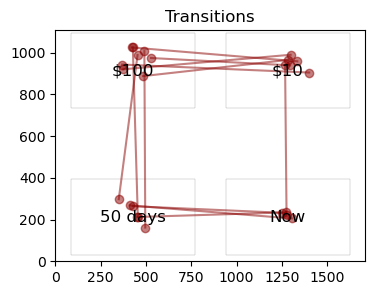

In [674]:

fig, ax = plt.subplots(figsize=(4,3))

ax.add_patch(patches.Rectangle(
    (gaze_region['#upperleft-div']['x']-1/2*marginWidth, gaze_region['#upperleft-div']['y']-1/2*marginHeight),
    gaze_region['#upperleft-div']['width']+marginWidth, gaze_region['#upperleft-div']['height']+marginHeight,
      edgecolor='black', facecolor='none', lw=0.1,
))
ax.add_patch(patches.Rectangle(
    (gaze_region['#upperright-div']['x']-1/2*marginWidth, gaze_region['#upperright-div']['y']-1/2*marginHeight),
    gaze_region['#upperright-div']['width']+marginWidth, gaze_region['#upperright-div']['height']+marginHeight,
    edgecolor='black', facecolor='none', lw=0.1, 
))


ax.add_patch(patches.Rectangle(
    (gaze_region['#lowerleft-div']['x']-1/2*marginWidth, gaze_region['#lowerleft-div']['y']-1/2*marginHeight),
    gaze_region['#lowerleft-div']['width']+marginWidth, gaze_region['#lowerleft-div']['height']+marginHeight,
      edgecolor='black', facecolor='none', lw=0.1,
))

ax.add_patch(patches.Rectangle(
    (gaze_region['#lowerright-div']['x']-1/2*marginWidth, gaze_region['#lowerright-div']['y']-1/2*marginHeight),
    gaze_region['#lowerright-div']['width']+marginWidth, gaze_region['#lowerright-div']['height']+marginHeight,
      edgecolor='black', facecolor='none', lw=0.1,
))


# Place text in the rectangles
ax.text(gaze_region['#upperleft-div']['x'] + gaze_region['#upperleft-div']['width'] / 2,
        gaze_region['#upperleft-div']['y'] + gaze_region['#upperleft-div']['height'] / 2,
        text_option_upperleft, ha='center', va='center', fontsize=12, color='black')

ax.text(gaze_region['#upperright-div']['x'] + gaze_region['#upperright-div']['width'] / 2,
        gaze_region['#upperright-div']['y'] + gaze_region['#upperright-div']['height'] / 2,
        text_option_upperright, ha='center', va='center', fontsize=12, color='black')

ax.text(gaze_region['#lowerleft-div']['x'] + gaze_region['#lowerleft-div']['width'] / 2,
        gaze_region['#lowerleft-div']['y'] + gaze_region['#lowerleft-div']['height'] / 2,
        text_option_lowerleft, ha='center', va='center', fontsize=12, color='black')

ax.text(gaze_region['#lowerright-div']['x'] + gaze_region['#lowerright-div']['width'] / 2,
        gaze_region['#lowerright-div']['y'] + gaze_region['#lowerright-div']['height'] / 2,
        text_option_lowerright, ha='center', va='center', fontsize=12, color='black')


for i in range(len(trial_fixation_data3)-1):
     ax.plot(
        [fixation_points[trial_fixation_data3.iloc[i]['roi']][0]+np.random.normal(20,50), fixation_points[trial_fixation_data3.iloc[i+1]['roi']][0]+np.random.normal(20,50)],
        [fixation_points[trial_fixation_data3.iloc[i]['roi']][1]+np.random.normal(20,50), fixation_points[trial_fixation_data3.iloc[i+1]['roi']][1]+np.random.normal(20,50)],
         'o-', color='darkred', alpha=0.5
    )
    
# Set limits, add titles, and legend
plt.title("Transitions")
plt.gca().invert_yaxis()  # Invert y-axis for correct orientation
plt.xlim(0, ww)
plt.ylim(0, wh)
plt.show()

### The Panye Index (PI) is calculated as follows:

$
PI = \frac{{(\text{{transitions within-option}} - \text{{transitions within-attribute}})}}{{(\text{{transitions within-option}} + \text{{transitions within-attribute}})}}]$
- Payne Index is calculated based on the number of within attribute transitions and the number of within alternative transitions
- A score of 1 represents a fully alternative-based search (most transitions within alternative).
- A score of –1.0 represents a fully attribute-based search (most transitions within attribute). 


In [677]:
within_option = [("upperleft_target", "lowerleft_target"), ("upperright_target", "lowerrright_target")]
within_attribute = [("upperleft_target", "upperright_target"), ("lowerleft_target", "lowerrright_target")]

In [679]:
def get_transitions(df, column_name):
    transition_tuples = []
    for i in range(len(df) - 1):
        current_value = df.loc[i, column_name]
        next_value = df.loc[i + 1, column_name]
        transition_tuples.append((current_value, next_value))
    return transition_tuples

def count_transitions(transitions, within_option, within_attribute):
    within_option_count = 0
    within_attribute_count = 0
    
    for transition in transitions:
        if transition in within_option:
            within_option_count += 1
        elif transition in within_attribute:
            within_attribute_count += 1
    return within_option_count, within_attribute_count

In [681]:
transitions = get_transitions(trial_fixation_data3, 'roi')  
within_option_count, within_attribute_count = count_transitions(transitions, within_option, within_attribute)
pi = (within_option_count-within_attribute_count)/(within_option_count +within_attribute_count )
print("Panye Index is : ", pi)

Panye Index is :  -0.3333333333333333


### Other tools for analyzing eye-tracking data:
- https://github.com/adolphslab/adolphslab_eyetracking

### Other applications such as consumer experience? video? 

### How to improve data quality 
- Instead of excluding participants, consider adding AOI (Area of Interest) corrections.  
  - [Reference: AOI corrections](https://link.springer.com/content/pdf/10.3758/s13428-023-02221-2.pdf)

- Use common smoothing algorithms and outlier removal techniques to improve data quality, such as low-pass filtering and Kalman filtering, to address issues like saccades and blinks.

- If the study requires extensive eye-tracking data from each participant, consider adding inter-trial calibration dots.  
  - [Reference: Inter-trial calibration](https://www.proquest.com/docview/2604578048?fromopenview=true&pq-origsite=gscholar&sourcetype=Scholarly%20Journals)
 
- virtual chinrest for adjusting the viewing distance:
    - https://www.jspsych.org/v7/plugins/virtual-chinrest/
